In [1]:
import os

# Path to your dataset folder
dataset_path = "./pistachios"

# Check if the folder exists
if os.path.exists(dataset_path):
    print(f"Dataset found in: {os.path.abspath(dataset_path)}")
else:
    print("Dataset folder not found! Please make sure 'pistachios' is in the same directory as this notebook.")


Dataset found in: c:\Users\user\Documents\Projects\GITHUB\Deep Learning\Image Denoising with Autoencoder Networks\pistachios


Resizes the image size

In [ ]:
from PIL import Image
import os
import numpy as np

def load_images(folder, size=(100, 100)): #reshapes the image size
    images = []
    for filename in sorted(os.listdir(folder)):
        path = os.path.join(folder, filename)
        try:
            img = Image.open(path).convert('RGB').resize(size)
            images.append(np.array(img) / 255.0)
        except Exception as e:
            print(f"Skipping {filename}: {e}")
    return np.array(images)

image_folder = '/content/DLQ2_dataset/B_23'
images = load_images(image_folder)
print("Images loaded:", images.shape)

Images loaded: (1074, 100, 100, 3)


EDA

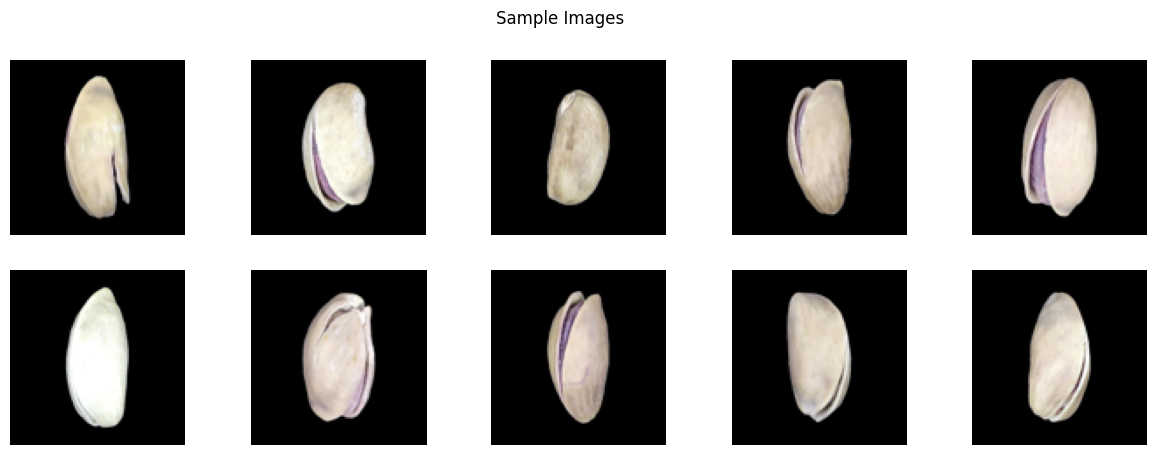

In [ ]:
import matplotlib.pyplot as plt

def show_image_grid(images, rows=2, cols=5, title="Sample Images"):
    plt.figure(figsize=(15, 5))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_image_grid(images, rows=2, cols=5)


The background is solid black which means the pictures have low texture and are uniform.

Focus on the pistachio's shell texture


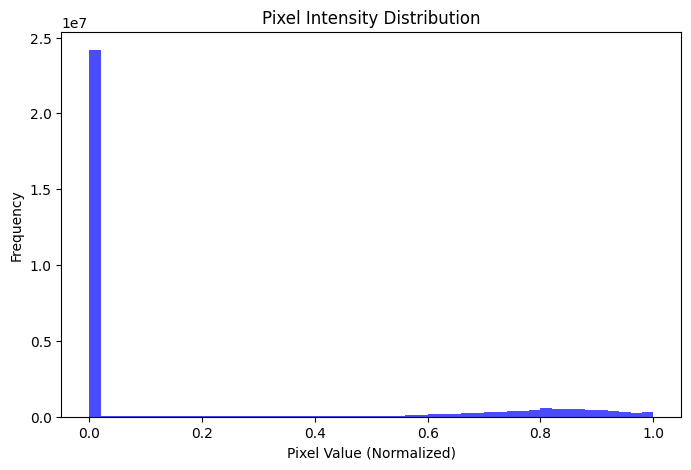

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(images.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value (Normalized)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_temp = train_test_split(images, test_size=0.2, random_state=42)


X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 859, Val: 107, Test: 108


Adding noise to the data

In [ ]:
def add_noise(imgs, mean=0.0, std=0.1):
    noise = np.random.normal(mean, std, imgs.shape)
    return np.clip(imgs + noise, 0., 1.)

X_train_noisy = add_noise(X_train)
X_val_noisy = add_noise(X_val)
X_test_noisy = add_noise(X_test)


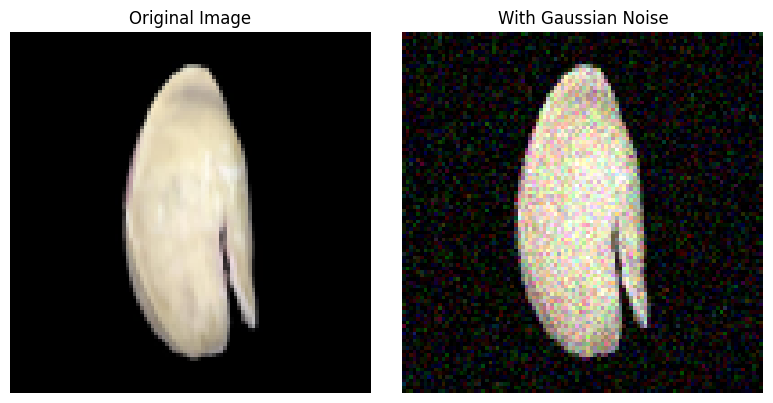

In [9]:
sample_img = images[0]
noisy_sample = add_noise(sample_img[np.newaxis, ...])[0]

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_sample)
plt.title("With Gaussian Noise")
plt.axis('off')

plt.tight_layout()
plt.show()

Baseline Model

In [12]:
from tensorflow.keras import layers, models

def autoencoderBaseline(input_shape=(100, 100, 3)):
    input_img = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [13]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = autoencoder.fit(
    X_train_noisy, X_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_noisy, X_val)
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 0.1330 - val_loss: 0.0130
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0123 - val_loss: 0.0120
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0336 - val_loss: 0.0156
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0119 - val_loss: 0.0071
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0065 - val_loss: 0.0036
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.

In [71]:
baseline_test_loss = autoencoder.evaluate(X_test_noisy, X_test)
print("Test MSE Loss:", baseline_test_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0012
Test MSE Loss: 0.0012324206763878465


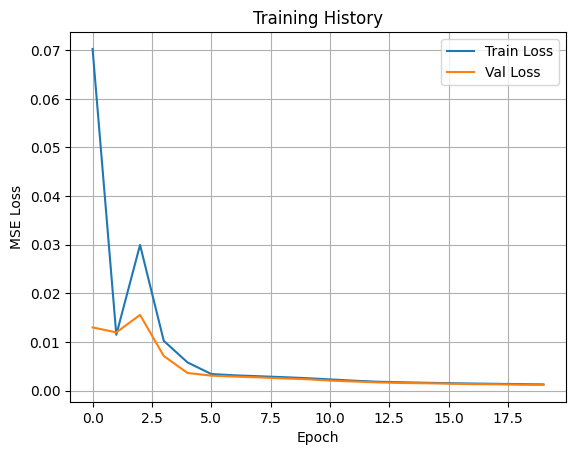

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
from skimage.metrics import structural_similarity as ssim

In [28]:
def calculate_ssim_batch(ground_truth, predicted):
    ssim_scores = []
    for i in range(len(ground_truth)):
        gt_img = (ground_truth[i] * 255).astype(np.uint8)
        pred_img = (predicted[i] * 255).astype(np.uint8)


        score = ssim(gt_img, pred_img, channel_axis=2)
        ssim_scores.append(score)

    return np.mean(ssim_scores)


In [80]:
decoded_imgs = autoencoder.predict(X_test_noisy)

ssim_baseline = calculate_ssim_batch(X_test, decoded_imgs)
print(f"Baseline SSIM: {ssim_baseline:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Baseline SSIM: 0.9356


In [87]:
res = {
    'Model': ["Baseline Model"],
    'SSIM': [ssim_baseline],
    'MSE' : [baseline_test_loss]
}

In [65]:
def modified_autoencoder(input_shape=(100, 100, 3)):
    input_img = layers.Input(shape=input_shape)


    x = layers.Conv2D(32, (3, 3), padding='same')(input_img)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.LeakyReLU()(x)


    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.LeakyReLU()(x)

    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder


In [66]:
modified_autoencoder = modified_autoencoder()
modified_autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_17 (UpSampling2D) │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
history_mod = modified_autoencoder.fit(
    X_train_noisy, X_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val_noisy, X_val)
)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.1142 - val_loss: 0.0149
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0147 - val_loss: 0.0137
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0129 - val_loss: 0.0090
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0069 - val_loss: 0.0036
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 10/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 11/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 12/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.

In [82]:
modified_test_loss = modified_autoencoder.evaluate(X_test_noisy, X_test)
print("Test MSE Loss:", modified_test_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.4860e-04
Test MSE Loss: 0.0009407396428287029


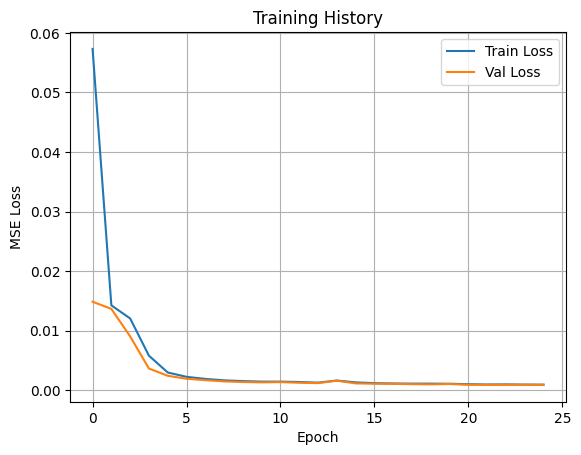

In [69]:
plt.plot(history_mod.history['loss'], label='Train Loss')
plt.plot(history_mod.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [84]:
decoded_imgs_mod = modified_autoencoder.predict(X_test_noisy)

ssim_modified = calculate_ssim_batch(X_test, decoded_imgs_mod)
print(f"Modified model SSIM: {ssim_modified:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Modified model SSIM: 0.9485


In [88]:
res['Model'].append('Modified Model')
res['SSIM'].append(ssim_modified)
res['MSE'].append(modified_test_loss)

In [89]:
import pandas as pd
df_results = pd.DataFrame(res)

Comparison

In [90]:
print(df_results)

            Model      SSIM       MSE
0  Baseline Model  0.935612  0.001232
1  Modified Model  0.948486  0.000941
